In [ ]:
from google.colab import drive
drive.mount('/drive')

import numpy as np
import pandas as pd

import scipy
from scipy.stats import poisson

import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
url = "https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures"
df_scores = pd.read_html(url)[0]


In [ ]:
df_scores.to_csv('../drive/MyDrive/data/Soccer/PremierLeague_Matches.csv')

In [ ]:
df_match = pd.read_csv('../drive/MyDrive/data/Soccer/PremierLeague_Matches.csv')

In [ ]:
df_match.head()

,Unnamed: 0,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,0,1.0,Fri,2022-08-05,20:00,Crystal Palace,1.2,0–2,1.0,Arsenal,25286.0,Selhurst Park,Anthony Taylor,Match Report,NaN
1,1,1.0,Sat,2022-08-06,12:30,Fulham,1.2,2–2,1.2,Liverpool,22207.0,Craven Cottage,Andy Madley,Match Report,NaN
2,2,1.0,Sat,2022-08-06,15:00,Tottenham,1.5,4–1,0.5,Southampton,61732.0,Tottenham Hotspur Stadium,Andre Marriner,Match Report,NaN
3,3,1.0,Sat,2022-08-06,15:00,Newcastle Utd,1.7,2–0,0.3,Nott'ham Forest,52245.0,St James' Park,Simon Hooper,Match Report,NaN
4,4,1.0,Sat,2022-08-06,15:00,Leeds United,0.8,2–1,1.3,Wolves,36347.0,Elland Road,Robert Jones,Match Report,NaN


In [ ]:
df_match = df_match[~df_match['Score'].isna()]

In [ ]:
# Drop NA rows
df_match.isna().sum()

In [ ]:
df_match.shape

(380, 15)

In [ ]:
df_match[['Home_Score','Away_Score']] = df_match['Score'].str.split('–', expand=True)

In [ ]:
df_match['Home_Score'] = df_match['Home_Score'].astype('int')
df_match['Away_Score'] = df_match['Away_Score'].astype('int')

## Hypothetical Match Between Liverpool and Chelsea

In [ ]:
df_liverpool = df_match.copy()
df_chelsea = df_match.copy()
df_liverpool = df_liverpool[(df_liverpool['Home']=='Liverpool') | (df_liverpool['Away']=='Liverpool')]
df_chelsea = df_chelsea[(df_chelsea['Home']=='Chelsea') | (df_chelsea['Away']=='Chelsea')]

In [ ]:
df_liverpool.shape, df_chelsea.shape

((38, 17), (38, 17))

In [ ]:
df_liverpool['Liverpool_Score'] = np.where(df_liverpool['Home']=='Liverpool', df_liverpool['Home_Score'],df_liverpool['Away_Score'])
df_chelsea['Chelsea_Score'] = np.where(df_chelsea['Home']=='Chelsea', df_chelsea['Home_Score'],df_chelsea['Away_Score'])

In [ ]:
liverpool_dist = df_liverpool['Liverpool_Score'].value_counts(normalize=True).sort_index()
chelsea_dist = df_chelsea['Chelsea_Score'].value_counts(normalize=True).sort_index()

In [ ]:
liverpool_dist, chelsea_dist, liverpool_dist.sum(), chelsea_dist.sum()

(0    0.210526
 1    0.263158
 2    0.263158
 3    0.131579
 4    0.052632
 6    0.026316
 7    0.026316
 9    0.026316
 Name: Liverpool_Score, dtype: float64,
 0    0.368421
 1    0.342105
 2    0.210526
 3    0.078947
 Name: Chelsea_Score, dtype: float64,
 1.0,
 1.0)

In [ ]:
poi_prob_liverpool = [poisson.pmf(k=i, mu=df_liverpool['Liverpool_Score']).mean() for i in np.arange(10)]
poi_prob_chelsea = [poisson.pmf(k=i, mu=df_chelsea['Chelsea_Score']).mean() for i in np.arange(10)]

In [ ]:
df_liverpool['Liverpool_Score'].mean(), df_chelsea['Chelsea_Score'].mean()

(1.9736842105263157, 1.0)

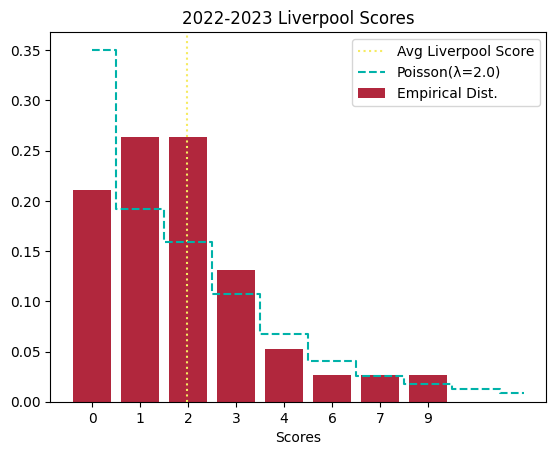

In [ ]:
sns.barplot(x=liverpool_dist.index, y=liverpool_dist.values, color='#C8102E', label='Empirical Dist.')
plt.axvline(x=df_liverpool['Liverpool_Score'].mean(), color='#F6EB61', label='Avg Liverpool Score', linestyle='dotted')
plt.step(x=np.arange(10), y=poi_prob_liverpool, where='mid', linestyle='dashed', color='#00B2A9', label=f"Poisson(λ={df_liverpool['Liverpool_Score'].mean().round(1)})")
plt.xticks(rotation=0)
plt.xlabel('Scores')
plt.title('2022-2023 Liverpool Scores')
plt.legend(loc='best')

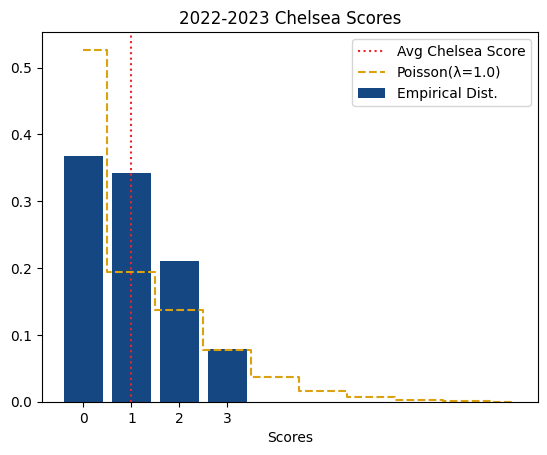

In [ ]:
sns.barplot(x=chelsea_dist.index, y=chelsea_dist.values, color='#034694', label='Empirical Dist.')
plt.axvline(x=df_chelsea['Chelsea_Score'].mean(), color='#EE242C', label='Avg Chelsea Score', linestyle='dotted')
plt.step(x=np.arange(10), y=poi_prob_chelsea, where='mid', linestyle='dashed', color='#DBA111', label=f"Poisson(λ={df_chelsea['Chelsea_Score'].mean().round(1)})")
plt.xticks(rotation=0)
plt.xlabel('Scores')
plt.title('2022-2023 Chelsea Scores')
plt.legend(loc='best')

### Fits are not great. Perform Chi-Square GOF Test to see if they significantly deviate from the fitted poisson distributions.

In [ ]:
from scipy.stats import chisquare, chi2

In [ ]:
df_liverpool['Liverpool_Score'].value_counts().sort_index()

0     8
1    10
2    10
3     5
4     2
6     1
7     1
9     1
Name: Liverpool_Score, dtype: int64

In [ ]:
liverpool_mean = df_liverpool['Liverpool_Score'].mean()
observed_data = df_liverpool['Liverpool_Score'].value_counts().sort_index().values
expected_data = np.array([poisson.pmf(k=i, mu=liverpool_mean) for i in df_liverpool['Liverpool_Score'].value_counts().sort_index().index])*len(df_liverpool)

In [ ]:
observed_data

array([ 8, 10, 10,  5,  2,  1,  1,  1])

In [ ]:
df_liv_data = pd.DataFrame({'Num_Goals': df_liverpool['Liverpool_Score'].value_counts().sort_index().index,
                            'Observed_Counts': observed_data})

In [ ]:
df_liv_data

,Num_Goals,Observed_Counts
0,0,8
1,1,10
2,2,10
3,3,5
4,4,2
5,6,1
6,7,1
7,9,1


In [ ]:
# Make number of goals regular (without skipping values)
df_liv_data2 = pd.DataFrame({'Num_Goals': range(df_liv_data['Num_Goals'].min(), df_liv_data['Num_Goals'].max()+1)})
df_liv_data2 = df_liv_data2.merge(df_liv_data, on='Num_Goals', how='left')
df_liv_data2.fillna(0, inplace=True)

In [ ]:
df_liv_data2['Expected_Counts'] = np.array([poisson.pmf(k=i, mu=liverpool_mean) for i in df_liv_data2['Num_Goals']])*len(df_liverpool)

In [ ]:
df_liv_data2

,Num_Goals,Observed_Counts,Expected_Counts
0,0,8.0,5.279872
1,1,10.0,10.420801
2,2,10.0,10.283685
3,3,5.0,6.765582
4,4,2.0,3.338281
5,5,0.0,1.317742
6,6,1.0,0.433468
7,7,1.0,0.122218
8,8,0.0,0.030153
9,9,1.0,0.006612


In [ ]:
# Combine the scoring 4 or more goals into one category
df_liv_temp1 = df_liv_data2.head(4)

In [ ]:
df_liv_temp2 = pd.DataFrame({'Num_Goals':['4+'],
                             'Observed_Counts':df_liv_data2['Observed_Counts'].iloc[4:].sum(),
                             'Expected_Counts':df_liv_data2['Expected_Counts'].iloc[4:].sum()})

In [ ]:
df_liv_data3 = pd.concat([df_liv_temp1, df_liv_temp2], ignore_index=True)

In [ ]:
df_liv_data3 # now we have enough in each category to carry out our goodness of fit test

,Num_Goals,Observed_Counts,Expected_Counts
0,0,8.0,5.279872
1,1,10.0,10.420801
2,2,10.0,10.283685
3,3,5.0,6.765582
4,4+,5.0,5.248474


In [ ]:
chisq_stat = ((df_liv_data3['Observed_Counts']-df_liv_data3['Expected_Counts'])**2/df_liv_data3['Expected_Counts']).sum()

In [ ]:
chisq_stat

1.8987144570131165

In [ ]:
# degrees of freedom = # of categories - # estimated parameters - 1 = 5 - 1 - 1 = 3
1-chi2.cdf(x=chisq_stat, df=3)

0.5936926169562622

In [ ]:
chi_square_test_statistic, p_value = chisquare(f_obs=df_liv_data3['Observed_Counts'].values.round(2),
                                               f_exp=df_liv_data3['Expected_Counts'].values.round(2),
                                               ddof=1)


In [ ]:
chi_square_test_statistic, p_value

(1.9004345111015934, 0.5933267754548466)

### Based on the above hypothesis test, we do not have sufficient evidence to say that the data is NOT from the corresponding Poisson distribution...

In [ ]:
1-poisson.cdf(k=3, mu=2.97)

0.34604719472598977

In [ ]:
poisson.cdf(k=2,mu=2.97)

0.4299448270711317

## Corresponding Analysis for League as a Whole

In [ ]:
away_score_dist = df_match['Away_Score'].value_counts().sort_index()/len(df_match['Away_Score'])
home_score_dist = df_match['Home_Score'].value_counts().sort_index()/len(df_match['Home_Score'])

In [ ]:
poi_prob_home = [poisson.pmf(k=i,mu=df_match['Home_Score'].mean()) for i in np.arange(10)]
poi_prob_away = [poisson.pmf(k=i,mu=df_match['Away_Score'].mean()) for i in np.arange(10)]
#poi_prob_all = [poisson.pmf(k=i,mu=df_all_scores.mean()) for i in np.arange(10)]

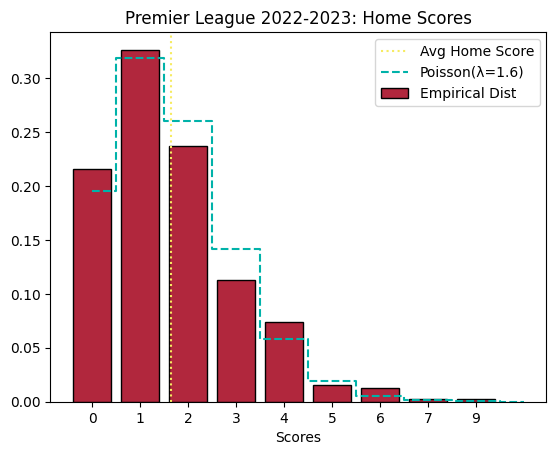

In [ ]:
sns.barplot(x=home_score_dist.index, y=home_score_dist.values, color='#C8102E', edgecolor='black', alpha=1, label='Empirical Dist')
plt.axvline(x=df_match['Home_Score'].mean(), color='#F6EB61', label='Avg Home Score', linestyle='dotted')
plt.step(x=np.arange(10), y=poi_prob_home, where='mid', linestyle='dashed', color='#00B2A9', label=f"Poisson(λ={df_match['Home_Score'].mean().round(1)})")
plt.xticks(rotation=0)
plt.xlabel('Scores')
plt.title('Premier League 2022-2023: Home Scores')
plt.legend(loc='best')

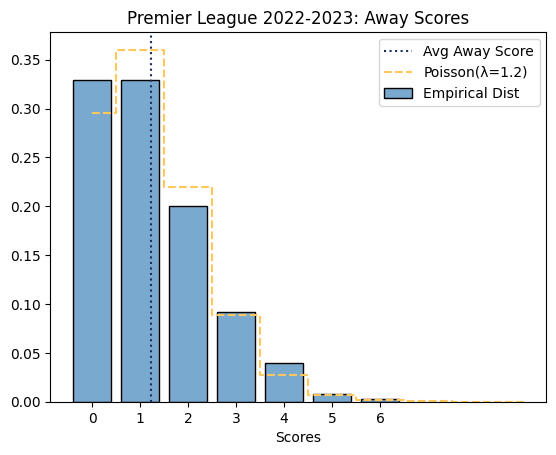

In [ ]:
sns.barplot(x=away_score_dist.index, y=away_score_dist.values, color='#6CABDD', edgecolor='black', alpha=1, label='Empirical Dist')
plt.axvline(x=df_match['Away_Score'].mean(), color='#1C2C5B', label='Avg Away Score', linestyle='dotted')
plt.step(x=np.arange(10), y=poi_prob_away, where='mid', linestyle='dashed', color='#FFC659', label=f"Poisson(λ={df_match['Away_Score'].mean().round(1)})")
plt.xticks(rotation=0)
plt.xlabel('Scores')
plt.title('Premier League 2022-2023: Away Scores')
plt.legend(loc='best')

In [ ]:
df_match['Home_Score'].mean(), df_match['Away_Score'].mean(), (df_match['Home_Score']+df_match['Away_Score']).mean()

(1.6342105263157896, 1.2184210526315788, 2.8526315789473684)

In [ ]:
df_match['Total_Score'] = df_match['Home_Score']+df_match['Away_Score']
total_score_dist = df_match['Total_Score'].value_counts().sort_index()/len(df_match['Total_Score'])
poi_prob_total = [poisson.pmf(k=i,mu=df_match['Total_Score'].mean()) for i in np.arange(10)]


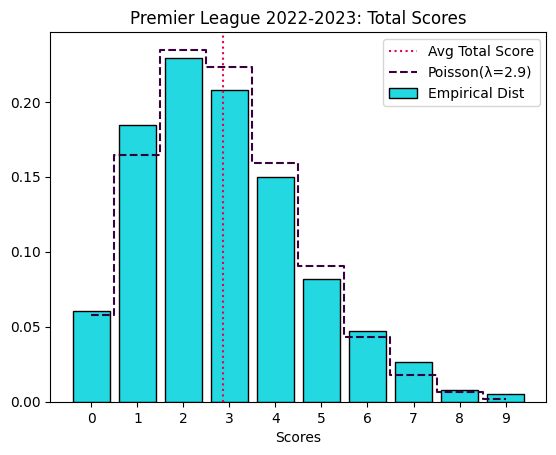

In [ ]:
sns.barplot(x=total_score_dist.index, y=total_score_dist.values, color='#04f5ff', edgecolor='black', alpha=1, label='Empirical Dist')
plt.axvline(x=df_match['Total_Score'].mean(), color='#e90052', label='Avg Total Score', linestyle='dotted')
plt.step(x=np.arange(10), y=poi_prob_total, where='mid', linestyle='dashed', color='#38003c', label=f"Poisson(λ={df_match['Total_Score'].mean().round(1)})")
plt.xticks(rotation=0)
plt.xlabel('Scores')
plt.title('Premier League 2022-2023: Total Scores')
plt.legend(loc='best')

In [ ]:
poisson.cdf(k=4, mu=df_match['Total_Score'].mean())

0.8393880885324787

In [ ]:
1-poisson.cdf(k=4, mu=df_match['Total_Score'].mean())

0.1606119114675213

In [ ]:
poisson.cdf(k=3, mu=df_match['Total_Score'].mean())

0.6802077782225837

## Team Strengths from Poisson Regression

In [ ]:
df_match.head()

,Unnamed: 0,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,Home_Score,Away_Score
0,0,1.0,Fri,2022-08-05,20:00,Crystal Palace,1.2,0–2,1.0,Arsenal,25286.0,Selhurst Park,Anthony Taylor,Match Report,NaN,0,2
1,1,1.0,Sat,2022-08-06,12:30,Fulham,1.2,2–2,1.2,Liverpool,22207.0,Craven Cottage,Andy Madley,Match Report,NaN,2,2
2,2,1.0,Sat,2022-08-06,15:00,Tottenham,1.5,4–1,0.5,Southampton,61732.0,Tottenham Hotspur Stadium,Andre Marriner,Match Report,NaN,4,1
3,3,1.0,Sat,2022-08-06,15:00,Newcastle Utd,1.7,2–0,0.3,Nott'ham Forest,52245.0,St James' Park,Simon Hooper,Match Report,NaN,2,0
4,4,1.0,Sat,2022-08-06,15:00,Leeds United,0.8,2–1,1.3,Wolves,36347.0,Elland Road,Robert Jones,Match Report,NaN,2,1


In [ ]:
def create_X(df, add_home_adv=False, add_intercept=False):
  # Dimensions of X
  n = len(df)
  p = df['Home'].nunique()

  # Initialize with 0s
  XH = np.zeros((n,p))

  # Sort teams
  team_sort = df['Home'].sort_values().unique()

  # Assign 1s and -1s accordingly
  for i in range(len(XH)):

    # Obtain team names for game i
    home_team = df['Home'].iloc[i]
    away_team = df['Away'].iloc[i]

    # Obtain corresponding indices
    home_idx = np.where(team_sort==home_team)[0][0]
    away_idx = np.where(team_sort==away_team)[0][0]

    # Assign values
    XH[i,home_idx] = 1
    XH[i,away_idx] = -1

  # Add Home Advantage
  if add_home_adv:
    XH = np.column_stack((XH, np.ones((XH.shape[0], 1))))

  # Create XA = -XH (except the intercept)
  XA = -1*XH

  # Stack (XH, XA)
  X = np.row_stack((XH, XA))

  # Add Intercept Column
  if add_intercept:
    X = np.column_stack((X, np.ones(X.shape[0])))

  return X



In [ ]:
X = create_X(df=df_match, add_home_adv=True, add_intercept=True)

In [ ]:
X.shape

(760, 22)

In [ ]:
X.sum(axis=0)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 760.])

In [ ]:
yH = df_match['Home_Score']
yA = df_match['Away_Score']
y = np.concatenate((yH, yA))

In [ ]:
yH.shape, yA.shape, y.shape

((380,), (380,), (760,))

In [ ]:
def create_W(df, add_home_adv=False, add_intercept=False):

  # Create the W matrix that is p x (p-1) where p = number of teams
  # Composed of a p-1 x p-1 idenity matrix with and additional row of all -1s
  p = df['Home'].nunique()
  W = np.identity(p)
  W[-1,:] = -1 # set last row to -1
  W = W[:,:-1] # remove last column

  if add_home_adv:
    W = scipy.linalg.block_diag(W, [1]) # adds extra row and column with all zeros except 1 on diagonal

  if add_intercept:
    W = scipy.linalg.block_diag(W, [1]) # adds extra row and column with all zeros except 1 on diagonal

  return W

In [ ]:
W = create_W(df=df_match, add_home_adv=True, add_intercept=True)

In [ ]:
W.shape

(22, 21)

In [ ]:
# Check last row
W[-1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1.])

In [ ]:
# Check second to last row
W[-2,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0.])

In [ ]:
# Check third to last rows
W[-3,:]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.,  0.,  0.])

In [ ]:
import statsmodels.api as sm

In [ ]:
# Poisson Regression Model
poi_reg = sm.GLM(endog=y, exog=X @ W, family=sm.families.Poisson()).fit()

In [ ]:
xnames = list(df_match['Home'].sort_values().unique())
xnames = xnames[:-1]
print(poi_reg.summary(xname=xnames + ['home_adv'] + ['intercept']))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  760
Model:                            GLM   Df Residuals:                      739
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1117.9
Date:                Thu, 29 Feb 2024   Deviance:                       868.97
Time:                        23:41:14   Pearson chi2:                     769.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1825
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Arsenal             0.3977      0.090     

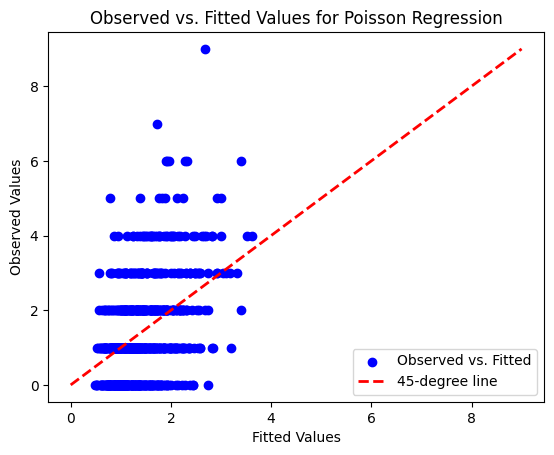

In [ ]:
plt.scatter(poi_reg.fittedvalues, y, c='blue', label='Observed vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Fitted Values for Poisson Regression')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', linewidth=2, label='45-degree line')
plt.legend()
plt.show()

In [ ]:
np.sqrt(((y-poi_reg.fittedvalues)**2).mean()) # RMSE = 1.2 ==> on average, our predictions are off by 1 goal

1.1994097710112062

In [ ]:
df_match['Home_W'] = np.where(df_match['Home_Score']>df_match['Away_Score'],1,0)
df_match['Home_L'] = np.where(df_match['Home_Score']<df_match['Away_Score'],1,0)
df_match['T'] = np.where(df_match['Home_Score']==df_match['Away_Score'],1,0)

df_match['Away_W'] = np.where(df_match['Home_Score']<df_match['Away_Score'],1,0)
df_match['Away_L'] = np.where(df_match['Home_Score']>df_match['Away_Score'],1,0)

In [ ]:
df_seasonH = df_match.groupby('Home')[['Home_W', 'Home_L', 'T']].agg('sum').reset_index().rename(columns={'Home':'Team','Home_W':'W','Home_L':'L'})
df_seasonA = df_match.groupby('Away')[['Away_W','Away_L', 'T']].agg('sum').reset_index().rename(columns={'Away':'Team', 'Away_W':'W', 'Away_L':'L'})
df_season = pd.concat([df_seasonH, df_seasonA], axis=0, ignore_index=True)
df_season = df_season.groupby('Team')[['W','L','T']].agg('sum').reset_index()

In [ ]:
df_season['Pts'] = 3*df_season['W']+df_season['T']

In [ ]:
df_season.sort_values('Pts',ascending=False)

,Team,W,L,T,Pts
12,Manchester City,28,5,5,89
0,Arsenal,26,6,6,84
13,Manchester Utd,23,9,6,75
14,Newcastle Utd,19,5,14,71
11,Liverpool,19,9,10,67
4,Brighton,18,12,8,62
1,Aston Villa,18,13,7,61
17,Tottenham,18,14,6,60
3,Brentford,15,9,14,59
8,Fulham,15,16,7,52


In [ ]:
theta = poi_reg.params[:-2] # team parameters only
beta_v = poi_reg.params[-2] # home advantage
beta0 = poi_reg.params[-1] # intercept

In [ ]:
theta_all = np.append(theta, -1*theta.sum()) # add in reference team

In [ ]:
df_strengths = pd.DataFrame(columns=['Team','Strengths','Std_Error'])
df_strengths['Team'] = xnames + ['Wolves', 'Home-Field Adv','Intercept']
all_ests = np.append(theta_all, beta_v)
all_ests = np.append(all_ests, beta0)
df_strengths['Strengths'] = all_ests

In [ ]:
vcov = poi_reg.cov_params()
theta_cov = vcov[:-2,:-2] # don't include home-field adv and intercept
ref_team_cov = theta_cov.sum()

In [ ]:
ref_team_cov, np.sqrt(ref_team_cov)

(0.008377463738373645, 0.0915284859394803)

In [ ]:
std_errs_v = np.append(np.sqrt(np.diagonal(theta_cov)), np.sqrt(ref_team_cov))
std_errs_v = np.append(std_errs_v, np.sqrt(vcov[-2,-2]))
std_errs_v = np.append(std_errs_v, np.sqrt(vcov[-1,-1]))
df_strengths['Std_Error'] = std_errs_v

In [ ]:
df_strengths

,Team,Strengths,Std_Error
0,Arsenal,0.397738,0.089751
1,Aston Villa,0.046342,0.092599
2,Bournemouth,-0.301802,0.090915
3,Brentford,0.109471,0.092415
4,Brighton,0.172173,0.092084
5,Chelsea,-0.080204,0.092510
6,Crystal Palace,-0.080204,0.092510
7,Everton,-0.205472,0.091825
8,Fulham,0.019217,0.092632
9,Leeds United,-0.267045,0.091280


<ipython-input-102-85339025bb8f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_strengths.iloc[:-2,:].sort_values('Strengths',ascending=False), y='Team', x='Strengths',orient='h', palette=color_palette)


Text(0.5, 0, 'Team Strengths')

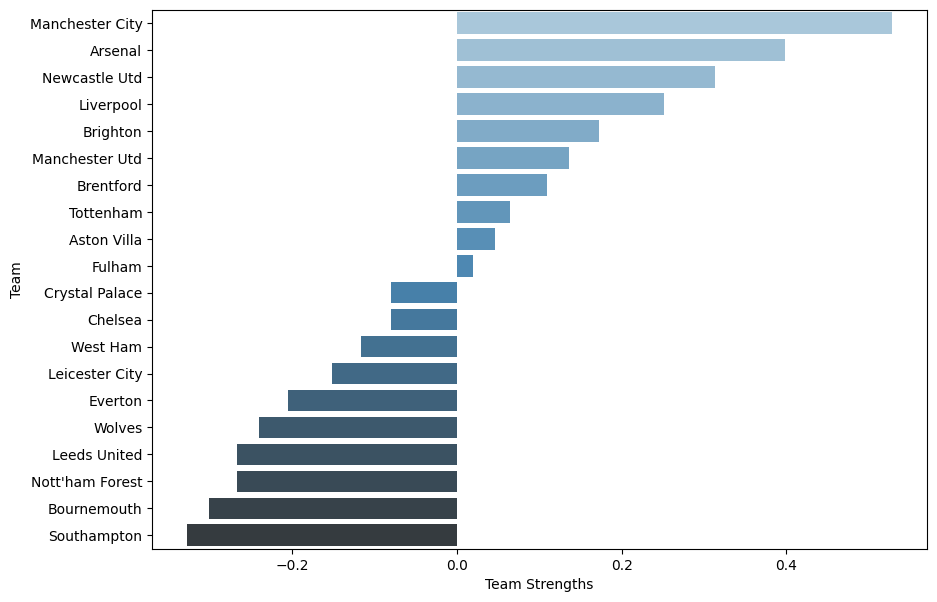

In [ ]:
plt.figure(figsize=(10,7))
color_palette = sns.color_palette('Blues_d', len(df_strengths)-2)
sns.barplot(df_strengths.iloc[:-2,:].sort_values('Strengths',ascending=False), y='Team', x='Strengths',orient='h', palette=color_palette)
plt.xlabel('Team Strengths')